Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


  0%|          | 0/50 [00:00<?, ?it/s]

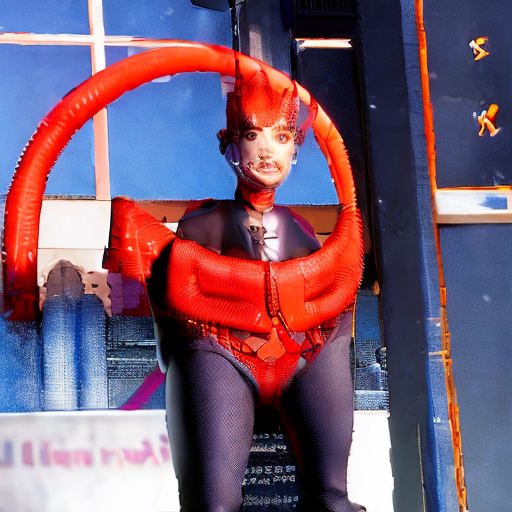

In [7]:
import torch
from diffusers import StableDiffusionPipeline

# Paths to the model safetensors files
base_model_path = "stabilityai/stable-diffusion-2-1"  # Base model (Stable Diffusion 2.1)
clip_model_path = "stabilityai/stable-diffusion-2-1-unclip"  # SD2.1 UnCLIP model
urpm_model_path = "mrcuddle/urpm-sd2.1"  # URPM model (your custom model)

# Load the models from diffusers
base_model = StableDiffusionPipeline.from_pretrained(base_model_path, torch_dtype=torch.float16)
clip_model = StableDiffusionPipeline.from_pretrained(clip_model_path, torch_dtype=torch.float16)
urpm_model = StableDiffusionPipeline.from_pretrained(urpm_model_path, torch_dtype=torch.float16)

# Access the UNet components from all models
base_unet = base_model.unet
clip_unet = clip_model.unet
urpm_unet = urpm_model.unet

# Initialize a dictionary to store the merged weights
merged_weights = {}

# Apply the operation: clip + (urpm - base) * 1
for key in base_unet.state_dict().keys():
    if key in clip_unet.state_dict() and key in urpm_unet.state_dict():
        base_weight = base_unet.state_dict()[key]
        clip_weight = clip_unet.state_dict()[key]
        urpm_weight = urpm_unet.state_dict()[key]
        
        # Apply clip + (urpm - base) * 1
        merged_weights[key] = clip_weight + (urpm_weight - base_weight)  # Equation: clip + (urpm - base) * 1

# Apply the merged weights to the base model's UNet
base_unet.load_state_dict(merged_weights)

# Move the model to GPU for inference
base_model.to("cuda")

# Generate random latents for unconditional generation (ensure dtype is float16)
latents = torch.randn((1, 4, 64, 64), device="cuda", dtype=torch.float16)

# Use an empty string or None for an unconditional generation
prompt = ""  # Empty prompt for unconditional generation

# Generate an image using the merged model
image = base_model(prompt=prompt, latents=latents, guidance_scale=7.5).images[0]

# Show the generated image
image.show()

# Optionally, save the merged model
base_model.save_pretrained("merged_model")

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

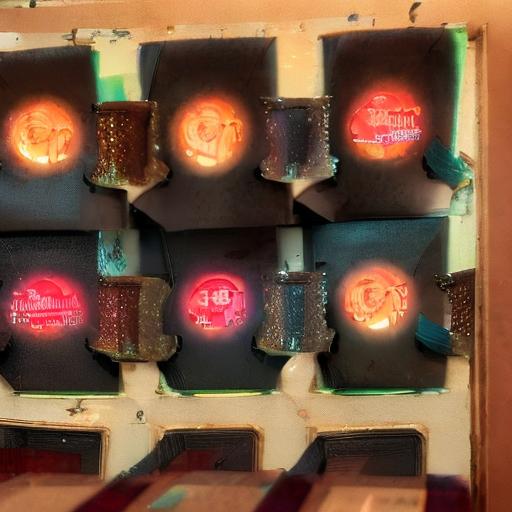

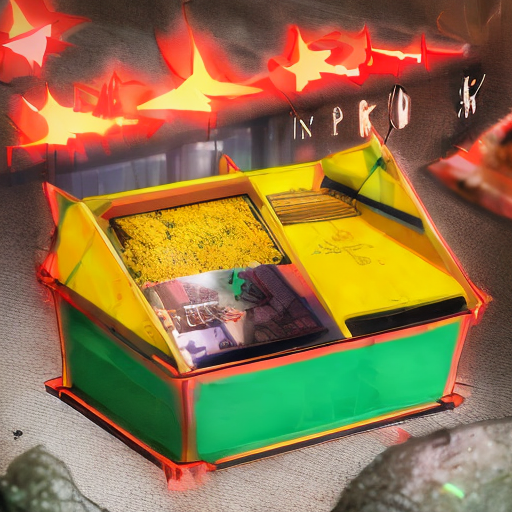

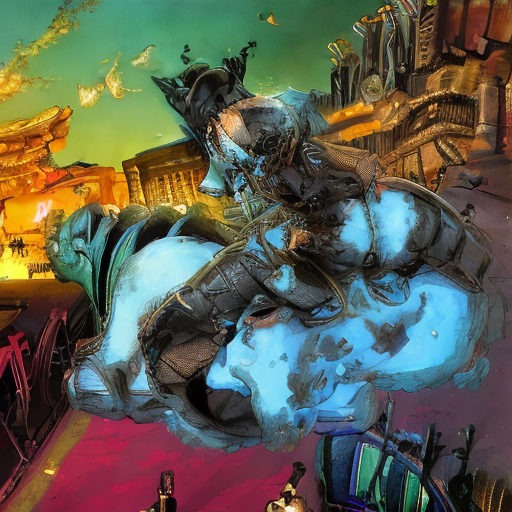

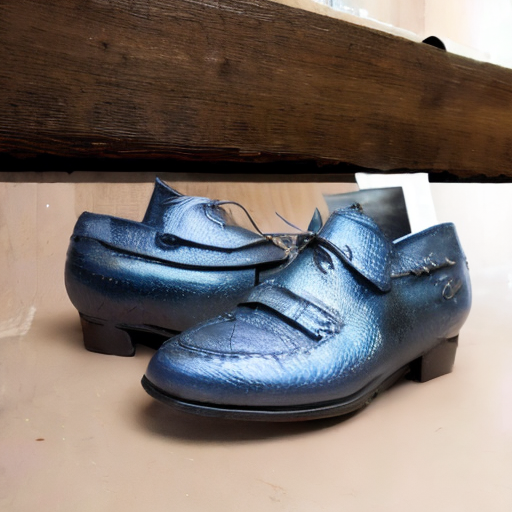

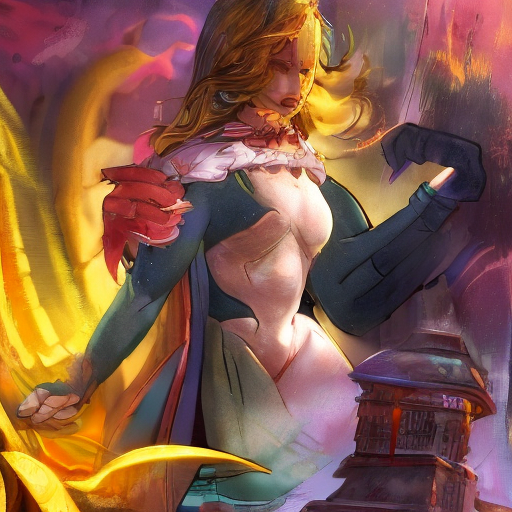

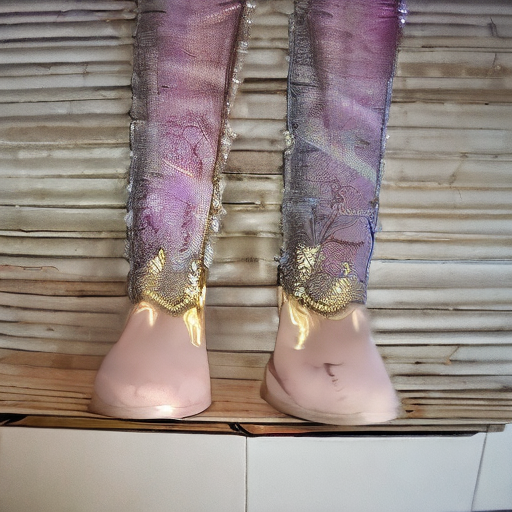

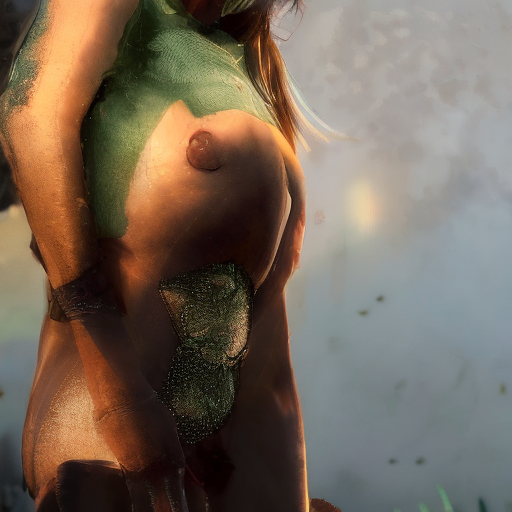

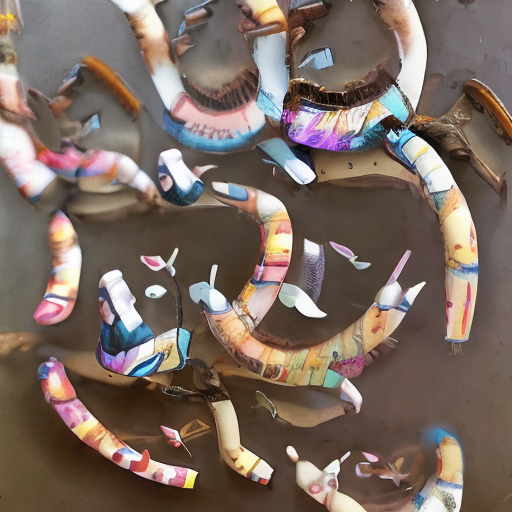

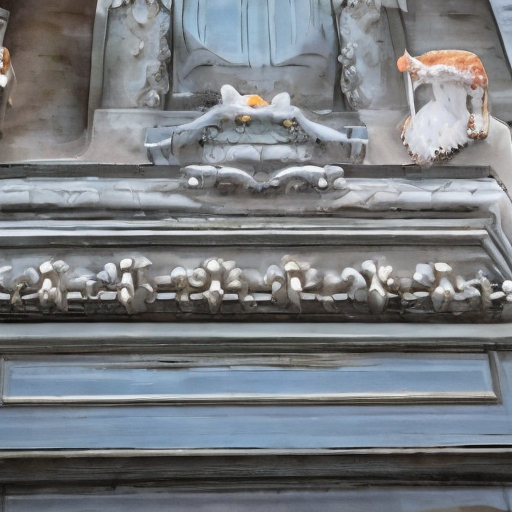

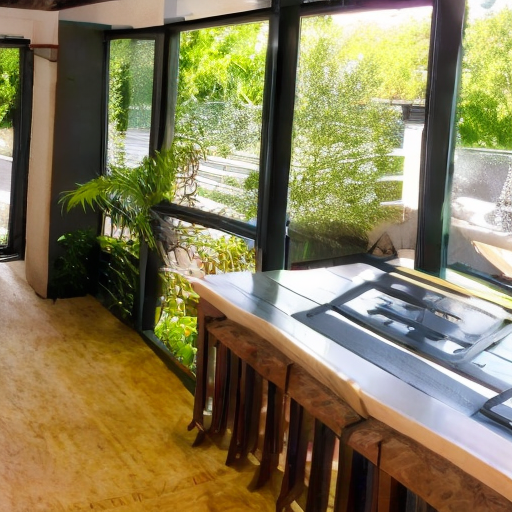

In [20]:
num_images_to_generate = 10
generated_images = []

for i in range(num_images_to_generate):
    # Generate a random latent for each image
    latents = torch.randn((1, 4, 64, 64), device="cuda", dtype=torch.float16)

    # Generate a random image with the same unconditional prompt
    image = base_model(prompt="", latents=latents, guidance_scale=7.5).images[0]
    
    generated_images.append(image)

# Display all generated images
for i, img in enumerate(generated_images):
    img.show(title=f"Generated Image {i + 1}")